In [1]:
import os
from copy import deepcopy
from tqdm import tqdm

import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torch.func import jacrev, vmap

In [2]:
torch.cuda.manual_seed(0)
torch.manual_seed(0)

In [3]:
## variables
os.environ['DATA_PATH'] = "/scratch/bbjr/dbeaglehole/"
dataset = 'cifar'
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
n = 500
NUM_LAYERS = 6
NUM_EPOCHS = 500 #15000
# model_type = 'resnet18'
model_type = 'mlp'

In [4]:
def mat_cov(A, B):
    A_ = A.reshape(-1).clone()
    B_ = B.reshape(-1).clone().to(A_.device)
    
    A_ -= A_.mean()
    B_ -= B_.mean()
    
    norm1 = A_.norm()
    norm2 = B_.norm()
    
    return (torch.dot(A_, B_) / norm1 / norm2).item()

def one_hot_data(dataset, num_classes, num_samples):
    Xs = []
    ys = []

    for ix in range(min(len(dataset),num_samples)):
        X,y = dataset[ix]
        Xs.append(X)

        ohe_y = torch.zeros(num_classes)
        ohe_y[y] = 1
        ys.append(ohe_y)

    return torch.stack(Xs), torch.stack(ys)

def get_binary(dataset, classes):
    c1, c2 = classes
    
    binary_dataset = []
    for ix in range(len(dataset)):
        X,y = dataset[ix]
        
        if y==c1:
            binary_dataset.append((X,0))
        elif y==c2:
            binary_dataset.append((X,1))

    return binary_dataset

def get_classes(dataset, classes):
    
    sub_dataset = []
    for ix in range(len(dataset)):
        X,y = dataset[ix]
        
        if y in classes:
            newc = classes.index(y)
            sub_dataset.append((X,newc))

    return sub_dataset

if dataset=='mnist':
    transform = transforms.Compose(
        [
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
        ]
    )

    path = os.environ["DATA_PATH"] + "MNIST/"
    trainset = torchvision.datasets.MNIST(root=path,
                                        train = True,
                                        transform=transform,
                                        download=True)
    testset = torchvision.datasets.MNIST(root=path,
                                        train = False,
                                        transform=transform,
                                        download=True)
elif dataset=='cifar':
    transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
        ]
    )

    path = os.environ["DATA_PATH"] + "cifar10/"

    trainset = torchvision.datasets.CIFAR10(root=path,
                                            train=True,
                                            transform=transform,
                                            download=True)
    testset = torchvision.datasets.CIFAR10(root=path,
                                           train=False,
                                           transform=transform,
                                           download=True)

NUM_CLASSES = 10


# classes = [0,1,2,3]
# NUM_CLASSES = len(classes)
# trainset = get_classes(trainset, classes=classes)
# testset = get_classes(testset, classes=classes)

train_X_, train_y_ = one_hot_data(trainset, NUM_CLASSES, num_samples=n)
test_X_, test_y_ = one_hot_data(testset, NUM_CLASSES, num_samples=n)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_X_ = train_X_.cuda()
train_y_ = train_y_.cuda()
test_X_ = test_X_.cuda()
test_y_ = test_y_.cuda()

In [6]:
## reorder data
newXs = []
newYs = []
for c in range(NUM_CLASSES):
    class1_idx = train_y_[:,c] == 1
    newYs.append(train_y_[class1_idx])
    newXs.append(train_X_[class1_idx])

train_X_ = torch.concat(newXs,dim=0)
train_y_ = torch.concat(newYs,dim=0)
print(train_X_.shape, train_y_.shape)

torch.Size([500, 3, 32, 32]) torch.Size([500, 10])


In [7]:
## -1,+1 labels
train_y_ -= 0.5
train_y_ *= 2

test_y_ -= 0.5
test_y_ *= 2

In [8]:
if model_type == 'mlp':
    train_X = train_X_.reshape(len(train_X_),-1)#.double()
    test_X = test_X_.reshape(len(test_X_),-1)#.double()
else:
    train_X = train_X_
    test_X = test_X_
    
train_y = train_y_.to(train_X_.dtype)
test_y = test_y_.to(test_X_.dtype)

In [9]:
def preprocess(X):
    """
    X : (n, c, P, Q)
    """
    Xpp = X - X.mean(dim=0)
    Xpp /= X.std(dim=0).unsqueeze(0)
    return Xpp

In [10]:
train_X = preprocess(train_X)
test_X = preprocess(test_X)

In [11]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
            return len(self.y)

    def __getitem__(self, idx):
            X_mb = self.X[idx]
            y_mb = self.y[idx]
            return (X_mb, y_mb)
    
mb_size = 128
train_loader = torch.utils.data.DataLoader(MyDataset(train_X, train_y), batch_size=mb_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(MyDataset(test_X, test_y), batch_size=mb_size, shuffle=True)

In [12]:
def matrix_sqrt(M, thresh=False):
    S, V = torch.linalg.eigh(M)
    S[S<0] = 0

    if thresh:
        # k = int(3*len(S)//4)
        k = -5
        S[:k] = 0

    S = torch.diag(S**0.5)
    return V @ S @ V.T

def fix_speeds(model, layer_to_fix, C=20, eps=1e-1):
    for i, layer in enumerate(model.layers):
        
        if isinstance(layer, nn.Linear):
            linear_layer = layer
          
        else:
            linear_layer = layer[0]
            
        linear_layer.weight.grad /= (eps + linear_layer.weight.grad.norm())
        
        if i==layer_to_fix:
            # print("before", linear_layer.weight.grad.norm())
            linear_layer.weight.grad *= C
            # print("after", linear_layer.weight.grad.norm())
        else:
            linear_layer.weight.grad /= C
        
        # linear_layer.weight.grad /= linear_layer.weight.grad.norm()
        # linear_layer.weight.grad *= linear_layer.weight.norm()
            
            
def train_step(net, lr, WD, momentum, train_loader, layer_to_fix=None, warmup=False):
    net.train()
    train_loss = 0.
    num_batches = len(train_loader)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=WD, momentum=momentum)
    for batch_idx, batch in enumerate(train_loader):
        
        if warmup:
            lr_ = lr * batch_idx/num_batches 
            optimizer = torch.optim.SGD(net.parameters(), lr=lr_, weight_decay=WD, momentum=momentum)
        
        optimizer.zero_grad()
        inputs, labels = batch
        targets = labels
        output = net(Variable(inputs)).float()
        target = Variable(targets).float()
        loss = criterion(output, target)
        loss.backward()
        
        # if layer_to_fix is not None:
        #     # print("Fixing", layer_to_fix)
        #     fix_speeds(net, layer_to_fix)
                   
        optimizer.step()
        train_loss += loss.cpu().data.numpy() * len(inputs)
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss


def val_step(net, val_loader):
    net.eval()
    val_loss = 0.
    for batch_idx, batch in enumerate(val_loader):
        inputs, labels = batch
        targets = labels
        with torch.no_grad():
            output = net(Variable(inputs))
            target = Variable(targets)
        loss = criterion(output, target)
        val_loss += loss.cpu().data.numpy() * len(inputs)
    val_loss = val_loss / len(val_loader.dataset)
    return val_loss

class Activation(nn.Module):
    def __init__(self):
        super(Activation, self).__init__()
    def forward(self, x):
        return nn.ReLU()(x)
        
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x, perturb=None):
        if perturb is not None:
            x = x + perturb   
        for layer in self.layers:
            x = layer(x)
        return x

In [13]:
def getW(model, layer):
    model_layer = model.layers[layer]
    return model_layer[0].weight.data
        
def get_class_variance(X, y):
    
    embeddings = [[] for _ in range(NUM_CLASSES)]
    for x, y in zip(X, y):
        c = torch.argmax(y)
        embeddings[c].append(x)
        
    embeddings = [torch.stack(Xc) for Xc in embeddings]
    class_counts = [len(embeddings[c]) for c in range(NUM_CLASSES)]
    class_means = torch.stack([Xc.mean(dim=0) for Xc in embeddings])
    
    
    muG = class_means.mean(dim=0).unsqueeze(0)
    SigmaB = (class_means - muG).T @ (class_means - muG)
    
    SigmaW = 0.
    SigmaT = 0.
    
    for c in range(NUM_CLASSES):
        muC = class_means[c].unsqueeze(0)
        Xc = embeddings[c]
        
        SigmaWc = (Xc - muC).T @ (Xc - muC)
        SigmaW += SigmaWc
        
        SigmaTc = (Xc - muG).T @ (Xc - muG)
        SigmaT += SigmaTc
        
    SigmaB /= NUM_CLASSES
    SigmaW /= (NUM_CLASSES * n)
    SigmaT /= (NUM_CLASSES * n)

    return SigmaB, SigmaW, SigmaT, class_means

In [14]:
def measure_agop(net, X):
    def get_jacobian(X_):
        def fnet_single(x_):
            return net(x_.unsqueeze(0)).squeeze(0)
        return vmap(jacrev(fnet_single))(X_).detach()
    
    
    n, d = X.shape
    grad = get_jacobian(X)
    grad = grad.reshape(-1, d)
    agop = grad.T @ grad

    return agop

In [15]:
def get_fmap(net_, last_layer):
    if last_layer==0:
        return nn.Identity()
    return nn.Sequential(*net_.layers[:last_layer]).eval()
    
def get_submodel(net_, last_layer):
    return nn.Sequential(*net_.layers[last_layer:]).eval()


def get_fmap_resnet(net_, last_layer):
    resnet = net_[0]
    mlp = net_[1]
    return nn.Sequential(*[resnet, get_fmap(mlp, last_layer)]).eval()

In [16]:
PRINT_EVERY = 25
MEASURE_EVERY = 25

def train_network(net, train_loader, test_loader, num_epochs=NUM_EPOCHS):

    params = 0
    for i, param in enumerate(list(net.parameters())):
        size = 1
        for j in range(len(param.size())):
            size *= param.size()[j]
            params += size

    print("NUMBER OF PARAMS: ", params)

    

    losses = []
    
    cov_Bs = []
    cov_Ws = []
    cov_Ts = []
    nfas = []
    all_agops = []
    models = []
    
    
    lr = 5e-3
    WD = 5e-4
    momentum = 0.9
    
    # optimizer = torch.optim.AdamW(net.parameters(), lr=5e-5)
    
    best_loss = float("inf")
    prev_train_loss = None
    layer_to_fix = None

    # lrs = torch.concat([torch.logspace(-4, -2, 3, base=10)] * (1 + num_epochs//3))
    # print(lrs)
    
    for i in range(num_epochs+1):
        
        # if i==100:
        #     lr = 1e-3
        #     optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=WD, momentum=momentum)
            
        if i==0:
            train_loss = train_step(net, lr, WD, momentum, train_loader, layer_to_fix, warmup=True)
        else:
            train_loss = train_step(net, lr, WD, momentum, train_loader, layer_to_fix, warmup=False)
            
        test_loss = val_step(net, test_loader)
        
        if prev_train_loss is None:
            prev_train_loss = train_loss
            
            
        # elif prev_train_loss < train_loss:
        # if i==7500:
        #     lr /= 2
        #     optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0., momentum=0.)
            
        
        
        losses.append(train_loss)

       
        if test_loss < best_loss:
            best_loss = test_loss
            
        
        
        if i%PRINT_EVERY==0:
            print("Epoch: ", i,
                  "Train Loss: ", train_loss, "Test Loss: ", test_loss,
                  "Best Test Loss: ", best_loss, "Layer to fix: ", layer_to_fix)
            
        if i%MEASURE_EVERY==0:
            cov_B = torch.zeros(NUM_LAYERS).to(train_X.device)
            cov_W = torch.zeros(NUM_LAYERS).to(train_X.device)
            cov_T = torch.zeros(NUM_LAYERS).to(train_X.device)
            nfa = torch.zeros(NUM_LAYERS).to(train_X.device)
            agops_t = []
            for layer in range(NUM_LAYERS):
                with torch.no_grad():
                    if model_type=='mlp':

                        fmap = get_fmap(net, layer)
                        sub_model = get_submodel(net, layer)

                        phiX = fmap(train_X)

                        with torch.no_grad():
                            agop = measure_agop(sub_model, phiX)

                        W = getW(net, layer)
                        nfm = W.T@W
                        
                        agops_t.append(agop.cpu())

                        nfa[layer] = mat_cov(agop, nfm)

                        fmap_next = get_fmap(net, layer+1)
                        phiX_next = fmap_next(train_X)
                        SigmaB, SigmaW, SigmaT, _ = get_class_variance(phiX_next, train_y)
                        cov_B[layer], cov_W[layer], cov_T[layer] = SigmaB.trace(), SigmaW.trace(), SigmaT.trace()

                    elif model_type=='resnet18':

                        fmap = get_fmap_resnet(net, layer)
                        phiX = fmap(train_X)

                        sub_model = get_submodel(net[1], layer)

                        agop = measure_agop(sub_model, phiX)

                        W = getW(net[1], layer)
                        nfm = W.T@W

                        nfa[layer] = mat_cov(agop, nfm)

                        fmap_next = get_fmap_resnet(net, layer+1)
                        phiX_next = fmap_next(train_X)
                        SigmaB, SigmaW, SigmaT, _ = get_class_variance(phiX_next, train_y)
                        cov_B[layer], cov_W[layer], cov_T[layer] = SigmaB.trace(), SigmaW.trace(), SigmaT.trace()


            cov_Bs.append(cov_B)
            cov_Ws.append(cov_W)
            cov_Ts.append(cov_T)
            nfas.append(nfa)
            all_agops.append(agops_t)
            
            net.cpu()
            models.append(deepcopy(net).eval())
            net.cuda()
            
            # print("nfa", nfa)
            layer_to_fix = torch.argmin(nfa).item()
            # print("layer to fix", layer_to_fix)
    return net, losses, cov_Bs, cov_Ws, cov_Ts, models, nfas, all_agops

In [17]:
if model_type=='mlp':
    inits = [0.1 for _ in range(NUM_LAYERS)]
    d = train_X.shape[1]
    k = 512
    layers = [
                nn.Sequential(nn.Linear(d, k), 
                                nn.BatchNorm1d(k),
                              Activation()
                             )
             ]
    # nn.init.xavier_uniform_(layers[-1][0].weight, gain=inits[0])

    for i in range(NUM_LAYERS - 1):
        layers += [
                    nn.Sequential(nn.Linear(k, k), 
                                    nn.BatchNorm1d(k),
                                  Activation()
                                 )
                ]
        # nn.init.xavier_uniform_(layers[-1][0].weight, gain=inits[1+i])

    layers += [nn.Linear(k, NUM_CLASSES, bias=False)]
    # layers[-1].weight.data /= 1000
    # layers += [nn.Softmax(dim=1)]

    model = MLP(layers)
    model.cuda()
    
elif model_type=='resnet18':
    
    layers = []
    for _ in range(NUM_LAYERS):
        layers += [
                    nn.Sequential(nn.Linear(512, 512, bias=False),
                                  Activation()
                                 )
                ]
        nn.init.xavier_normal_(layers[-1][0].weight, gain=0.5)
    layers += [nn.Linear(512, NUM_CLASSES, bias=False)]
    mlp = MLP(layers)
        
    resnet = torchvision.models.resnet18(weights=None)
    
    _, c, _, _ = train_X.shape
    num_channels = resnet.conv1.weight.shape[0]
    resnet.conv1 = nn.Conv2d(c, num_channels, kernel_size=7, stride=2, padding=3, bias=False)
    resnet.fc = nn.Identity()
    
    model = nn.Sequential(*[resnet, mlp])
    model.cuda()

In [18]:
model, losses, cov_Bs, cov_Ws, cov_Ts, models, nfas, all_agops = train_network(model, train_loader, test_loader)

NUMBER OF PARAMS:  2901002
Epoch:  0 Train Loss:  0.9925122432708741 Test Loss:  0.9773390564918518 Best Test Loss:  0.9773390564918518 Layer to fix:  None
Epoch:  25 Train Loss:  0.04199788162112236 Test Loss:  0.44028203225135804 Best Test Loss:  0.41783652687072753 Layer to fix:  5
Epoch:  50 Train Loss:  0.020036388874053956 Test Loss:  0.44508993792533874 Best Test Loss:  0.41783652687072753 Layer to fix:  5
Epoch:  75 Train Loss:  0.014384967982769012 Test Loss:  0.44443246436119077 Best Test Loss:  0.41783652687072753 Layer to fix:  5
Epoch:  100 Train Loss:  0.014871984332799912 Test Loss:  0.43765381717681884 Best Test Loss:  0.41783652687072753 Layer to fix:  5
Epoch:  125 Train Loss:  0.014564642429351807 Test Loss:  0.43534051060676576 Best Test Loss:  0.41783652687072753 Layer to fix:  5
Epoch:  150 Train Loss:  0.015256512239575385 Test Loss:  0.4313459093570709 Best Test Loss:  0.41783652687072753 Layer to fix:  5
Epoch:  175 Train Loss:  0.0142296384871006 Test Loss:  0

In [19]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

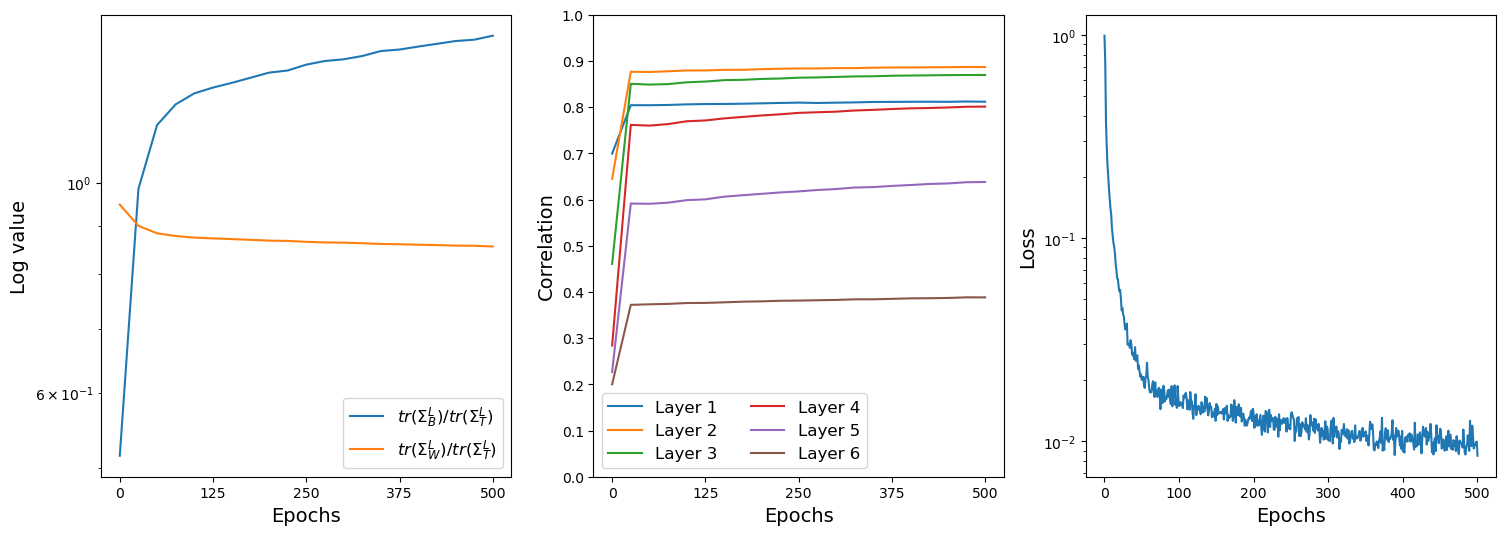

In [20]:
fs=14
fs2=12

try:
    plt.close()
except:
    pass

layer = 1
normalized_covB = np.array([x[-layer].detach().cpu() for x in cov_Bs])
normalized_covW = np.array([x[-layer].detach().cpu() for x in cov_Ws])
normalized_covT = np.array([x[-layer].detach().cpu() for x in cov_Ts])

# scale = max( np.max(normalized_covB), np.max(normalized_covW))
normalized_covW /= normalized_covT
normalized_covB /= normalized_covT

fig, axes = plt.subplots(1,3)

ax1, ax2, ax3 = axes

ax1.semilogy(np.arange(0, len(normalized_covB)*MEASURE_EVERY, MEASURE_EVERY), normalized_covB, label=r'$tr(\Sigma^L_B) / tr(\Sigma^L_T)$')
ax1.semilogy(np.arange(0, len(normalized_covW)*MEASURE_EVERY, MEASURE_EVERY), normalized_covW, label=r'$tr(\Sigma^L_W) / tr(\Sigma^L_T)$')

ax3.semilogy(losses)

for layer in range(NUM_LAYERS):
    nfa = [x[layer].cpu() for x in nfas]
    ax2.plot(np.arange(0, len(nfa)*MEASURE_EVERY, MEASURE_EVERY), nfa, label=f'Layer {layer+1}')

    
ax2.set_yticks(torch.linspace(0,1,11))

ax1.set_ylabel('Log value', fontsize=fs)
ax2.set_ylabel('Correlation', fontsize=fs)
ax3.set_ylabel('Loss', fontsize=fs)

step = NUM_EPOCHS // 4
xticks = np.arange(0, NUM_EPOCHS + step, step)
for ax in axes[:2]:
    ax.set_xticks(xticks)

axes[0].legend(fontsize=fs2, ncols=1)
axes[1].legend(fontsize=fs2, ncols=2)
    
for ax in axes:
    ax.set_xlabel("Epochs", fontsize=fs)
    
# fig.suptitle("Normalized feature variance throughout training", fontsize=fs)
fig.set_size_inches(18, 6)
plt.show()
# plt.savefig(f'nn_figures/{dataset}_n_{n}_nfa_nc_metrics.pdf', format='pdf')

## NC1 and NC2, SVD Plots

In [22]:
def get_NC2_from_means(u_, center=True):
    if center:
        u = u_ - u_.mean(dim=0).unsqueeze(0)
    else:
        u = u_.clone()
    u = u / u.norm(dim=1).unsqueeze(1)
    uu = u@u.T
    simplex = torch.eye(NUM_CLASSES) - torch.ones((NUM_CLASSES,NUM_CLASSES)) / (NUM_CLASSES - 1)
    simplex = simplex.to(u.device).to(u.dtype)
    return ((uu - simplex)**2).mean().item()

def get_NC2_yyT_from_means(u):
    u = u / u.norm(dim=1).unsqueeze(1)
    uuT = u@u.T
    
    
    mean_off_diag = (uuT.sum() - uuT.diag().sum()).item() / NUM_CLASSES / (NUM_CLASSES-1)
    off_diag = torch.ones_like(uuT)*mean_off_diag    
    uuT -= off_diag
    return mat_cov(uuT, torch.eye(NUM_CLASSES).to(u.device))

## svd measurements with agop

21it [00:10,  2.02it/s]
21it [00:02,  7.91it/s]
21it [00:02,  9.35it/s]
21it [00:02,  9.32it/s]
21it [00:02,  9.12it/s]
21it [00:02,  9.14it/s]


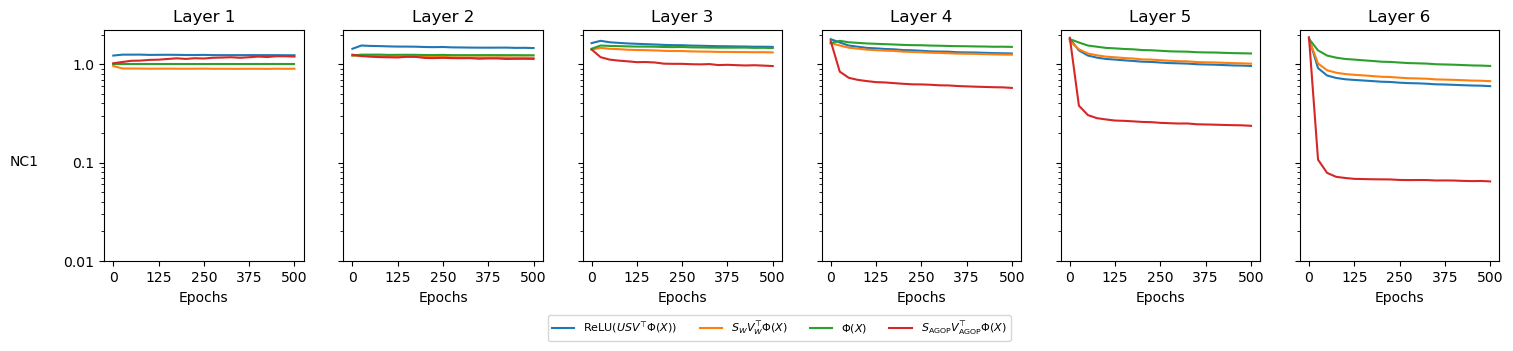

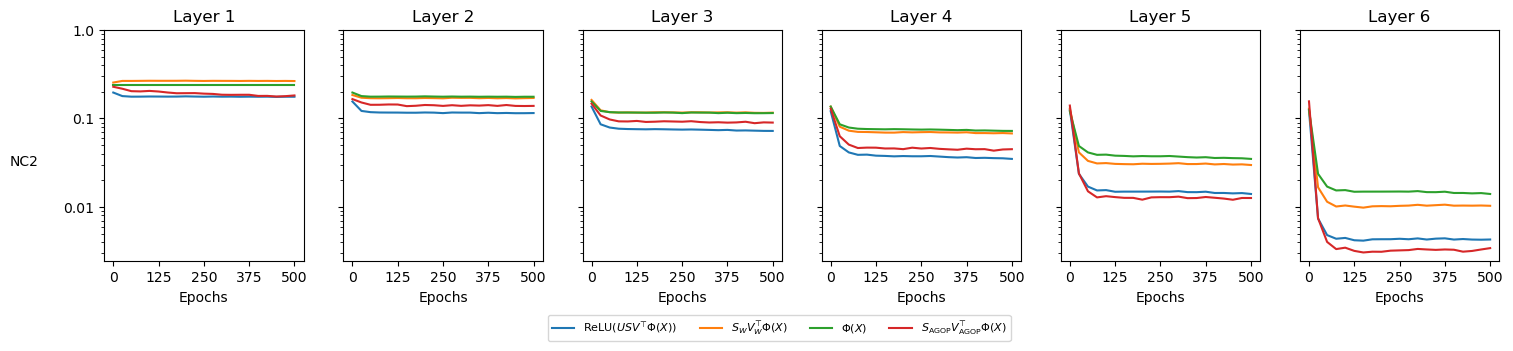

In [23]:
try:
    plt.close()
except:
    pass

fig1, axes1 = plt.subplots(1, NUM_LAYERS, sharey=True)
fig2, axes2 = plt.subplots(1, NUM_LAYERS, sharey=True)

xsteps = torch.arange(0, len(models)*MEASURE_EVERY, MEASURE_EVERY).cpu()

ymax_nc1 = 0
ymax_nc2 = 0
for layer in range(0, NUM_LAYERS):
    
    right_covsW_B = []
    left_covsW_B = []
    base_covsW_B = []
    agop_covsW_B = []
    
    left_covs_mu = []
    right_covs_mu = []
    base_covs_mu = []
    agop_covs_mu = []
    
    for model_idx, net in tqdm(enumerate(models)):
        net.cuda()
        if model_type=='mlp':
            W = getW(net, layer)
            fmap = get_fmap(net, layer)
        elif model_type=='resnet18':
            W = getW(net[1], layer)
            fmap = get_fmap_resnet(net, layer)
            
        phiX = fmap(train_X)
        
        # right calcs
        SigmaB, SigmaW, _, mus  = get_class_variance(phiX, train_y)
        covB, covW = SigmaB.trace().item(), SigmaW.trace().item()
        
        _, S, Vt = torch.linalg.svd(W)
        S = torch.diag(S)
        if S.shape[1] != Vt.shape[0]:
            newS = torch.zeros(S.shape[0], Vt.shape[0]).to(S.device)
            newS[:,:S.shape[1]] = S.clone()
            S = newS
        
        phiXr = phiX@Vt.T@S.T
        SigmaBr, SigmaWr, _, mus_r = get_class_variance(phiXr, train_y)
        covBr, covWr = SigmaBr.trace().item(), SigmaWr.trace().item()
        
        
        # left calcs
        phiXl = net.layers[layer](phiX)
        SigmaBl, SigmaWl, _, mus_l = get_class_variance(phiXl, train_y)
        covBl, covWl = SigmaBl.trace().item(), SigmaWl.trace().item()
        
        
        
        ## agop calcs
        agop = all_agops[model_idx][layer].cuda()
        Sa2, Va = torch.linalg.eigh(agop)
        Sa2[Sa2 < 0] = 0
        Sa = Sa2 ** 0.5
        Sa = torch.diag(Sa)
        
        phiXa = phiX@Va@Sa
        SigmaBa, SigmaWa, _, mus_a = get_class_variance(phiXa, train_y)
        covBa, covWa = SigmaBa.trace().item(), SigmaWa.trace().item()
        
        agop.cpu()
        
        
        
        base_covsW_B.append(covW/covB)
        right_covsW_B.append(covWr/covBr)
        left_covsW_B.append(covWl/covBl)
        agop_covsW_B.append(covWa/covBa)
        
        base_covs_mu.append(get_NC2_from_means(mus))
        right_covs_mu.append(get_NC2_from_means(mus_r))
        left_covs_mu.append(get_NC2_from_means(mus_l))
        agop_covs_mu.append(get_NC2_from_means(mus_a))
        
        net.cpu()
    
    

    ymax_nc1 = max([ymax_nc1] + left_covsW_B + right_covsW_B + base_covsW_B + agop_covsW_B)
    ymax_nc2 = max([ymax_nc2] + left_covs_mu + right_covs_mu + base_covs_mu + agop_covs_mu)
    
    ax1 = axes1[layer]
    ax1.semilogy(xsteps, left_covsW_B, label="left")
    ax1.semilogy(xsteps, right_covsW_B, label="right")
    ax1.semilogy(xsteps, base_covsW_B, label="none")
    ax1.semilogy(xsteps, agop_covsW_B, label="agop")
    
    ax2 = axes2[layer]
    ax2.semilogy(xsteps, left_covs_mu, label="left")
    ax2.semilogy(xsteps, right_covs_mu, label="right")
    ax2.semilogy(xsteps, base_covs_mu, label="none")
    ax2.semilogy(xsteps, agop_covs_mu, label="agop")
    #semilogy
    ax1.set_title(f'Layer {layer+1}')
    ax2.set_title(f'Layer {layer+1}')
    
    # ax.set_yticks(yticks)
    
    if layer==0:
        # ax1.set_ylabel(r'$tr(\Sigma_W) / tr(\Sigma_B)$', rotation=0)
        ax1.set_ylabel('NC1', rotation=0)
        ax1.yaxis.set_label_coords(-0.4,0.4)
        
        # ax2.set_ylabel(r'$\rho\left(\tilde{\mu}\tilde{\mu}^\top, I_K - \frac{1}{K-1}11^\top \right)$', rotation=0)
        ax2.set_ylabel('NC2', rotation=0)
        ax2.yaxis.set_label_coords(-0.4,0.4)
        
    
    step = (len(models)-1)*MEASURE_EVERY // 4
    xticks = np.arange(0, (len(models)-1)*MEASURE_EVERY + step, step)
    
    ax1.set_xticks(xticks)
    ax2.set_xticks(xticks)
    ax1.set_xlabel("Epochs")
    ax2.set_xlabel("Epochs")
    
def round_nearest(x, a):
    return (round(x / a) + 1) * a

# step = 0.1
# ymax_nc1 = round_nearest(ymax_nc1, step)
# yticks = np.arange(0,ymax_nc1 + step, step)
# yticklabels = [str(x) for x in yticks]
# axes1[0].set_yticks(yticks)
# axes1[0].set_yticklabels(yticklabels)

# ymax_nc2 = round_nearest(ymax_nc2, step)
# yticks = np.arange(0,ymax_nc2 + step, step)
# yticklabels = [str(x) for x in yticks]
# axes2[0].set_yticks(yticks)
# axes2[0].set_yticklabels(yticklabels)

yticks = [1e0,1e-1,1e-2]
yticklabels = [str(x) for x in yticks]
axes1[0].set_yticks(yticks)
axes1[0].set_yticklabels(yticklabels)

axes2[0].set_yticks(yticks)
axes2[0].set_yticklabels(yticklabels)
        
# axes1[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# axes2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

handles1, _ = axes1[-1].get_legend_handles_labels()
handles2, _ = axes2[-1].get_legend_handles_labels()
labels = [r'$\mathrm{ReLU} (U S V^\top \Phi(X))$',
        r'$S_W V_W^\top \Phi(X)$',
        r'$\Phi(X)$',
        r'$S_{\mathrm{AGOP}} V_{\mathrm{AGOP}}^\top \Phi(X)$']

fig1.legend(handles1, labels, loc="lower center", bbox_to_anchor=(0.5, -0.175), fontsize=8, ncols=4)
fig2.legend(handles2, labels, loc="lower center", bbox_to_anchor=(0.5, -0.175), fontsize=8, ncols=4)

fig1.set_size_inches(3*NUM_LAYERS, 3)
fig2.set_size_inches(3*NUM_LAYERS, 3)
plt.show()
# fig1.savefig(f'nn_figures/{dataset}_n_{n}_svd_nc1_metrics.pdf', format='pdf', bbox_inches="tight")
# fig2.savefig(f'nn_figures/{dataset}_n_{n}_svd_nc2_metrics.pdf', format='pdf', bbox_inches="tight")

### svd plots without agop

100%|██████████| 76/76 [00:02<00:00, 25.77it/s]


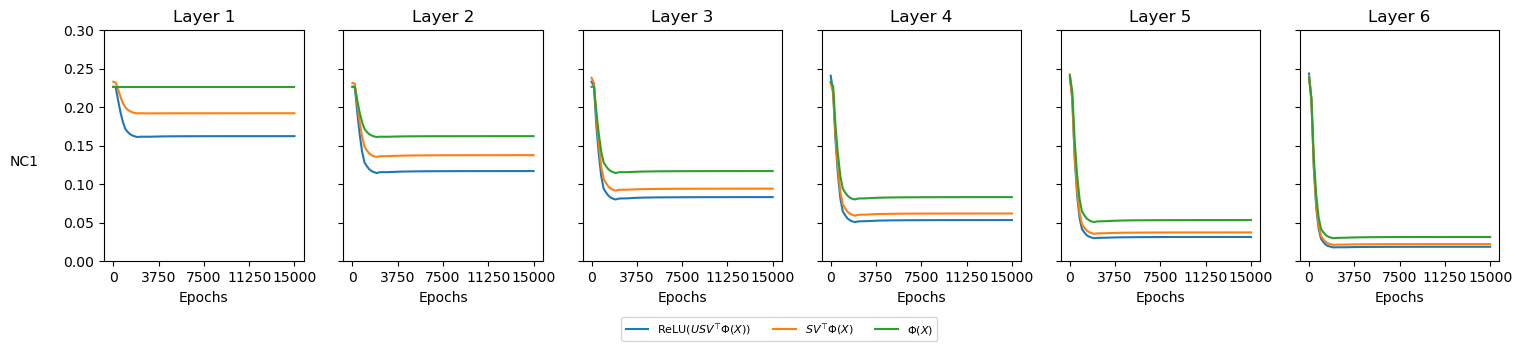

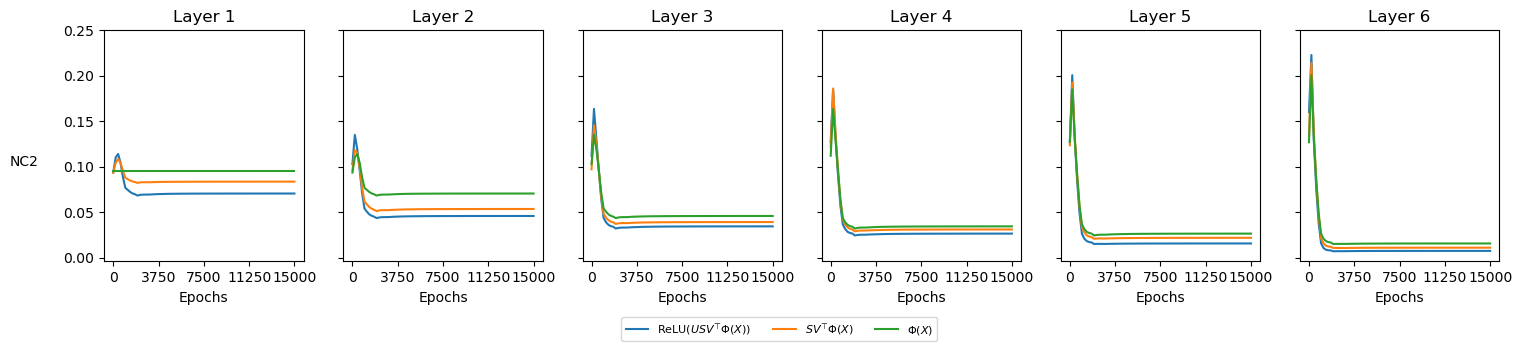

In [455]:
try:
    plt.close()
except:
    pass

fig1, axes1 = plt.subplots(1, NUM_LAYERS, sharey=True)
fig2, axes2 = plt.subplots(1, NUM_LAYERS, sharey=True)

xsteps = torch.arange(0, len(models)*MEASURE_EVERY, MEASURE_EVERY).cpu()

ymax_nc1 = 0
ymax_nc2 = 0
for layer in range(0, NUM_LAYERS):
    
    right_covsW_B = []
    left_covsW_B = []
    base_covsW_B = []
    
    left_covs_mu = []
    right_covs_mu = []
    base_covs_mu = []
    
    for net in tqdm(models):
        net.cuda()
        if model_type=='mlp':
            W = getW(net, layer)
            fmap = get_fmap(net, layer)
        elif model_type=='resnet18':
            W = getW(net[1], layer)
            fmap = get_fmap_resnet(net, layer)
            
        phiX = fmap(train_X)
        
        SigmaB, SigmaW, _, mus  = get_class_variance(phiX, train_y)
        covB, covW = SigmaB.trace().item(), SigmaW.trace().item()
        
        U, S, Vt = torch.linalg.svd(W)
        S = torch.diag(S)
        if S.shape[1] != Vt.shape[0]:
            newS = torch.zeros(S.shape[0], Vt.shape[0]).to(S.device)
            newS[:,:S.shape[1]] = S.clone()
            S = newS
        
        phiXr = phiX@Vt.T@S.T
        SigmaBr, SigmaWr, _, mus_r = get_class_variance(phiXr, train_y)
        covBr, covWr = SigmaBr.trace().item(), SigmaWr.trace().item()
        
        phiXl = Activation()(phiX@W.T)
        SigmaBl, SigmaWl, _, mus_l = get_class_variance(phiXl, train_y)
        covBl, covWl = SigmaBl.trace().item(), SigmaWl.trace().item()
        
        
        base_covsW_B.append(covW/covB)
        right_covsW_B.append(covWr/covBr)
        left_covsW_B.append(covWl/covBl)
        
        left_covs_mu.append(get_NC2_from_means(mus_l))
        right_covs_mu.append(get_NC2_from_means(mus_r))
        base_covs_mu.append(get_NC2_from_means(mus))
        
        net.cpu()
    
    

    ymax_nc1 = max([ymax_nc1] + left_covsW_B+right_covsW_B+base_covsW_B)
    ymax_nc2 = max([ymax_nc2] + left_covs_mu+right_covs_mu+base_covs_mu)
    
    ax1 = axes1[layer]
    ax1.plot(xsteps, left_covsW_B, label="left")
    ax1.plot(xsteps, right_covsW_B, label="right")
    ax1.plot(xsteps, base_covsW_B, label="none")
    
    ax2 = axes2[layer]
    ax2.plot(xsteps, left_covs_mu, label="left")
    ax2.plot(xsteps, right_covs_mu, label="right")
    ax2.plot(xsteps, base_covs_mu, label="none")
    #semilogy
    ax1.set_title(f'Layer {layer+1}')
    ax2.set_title(f'Layer {layer+1}')
    
    # ax.set_yticks(yticks)
    
    if layer==0:
        # ax1.set_ylabel(r'$tr(\Sigma_W) / tr(\Sigma_B)$', rotation=0)
        ax1.set_ylabel('NC1', rotation=0)
        ax1.yaxis.set_label_coords(-0.4,0.4)
        
        # ax2.set_ylabel(r'$\rho\left(\tilde{\mu}\tilde{\mu}^\top, I_K - \frac{1}{K-1}11^\top \right)$', rotation=0)
        ax2.set_ylabel('NC2', rotation=0)
        ax2.yaxis.set_label_coords(-0.4,0.4)
        
    
    step = (len(models)-1)*MEASURE_EVERY // 4
    xticks = np.arange(0, (len(models)-1)*MEASURE_EVERY + step, step)
    
    ax1.set_xticks(xticks)
    ax2.set_xticks(xticks)
    ax1.set_xlabel("Epochs")
    ax2.set_xlabel("Epochs")
    
def round_nearest(x, a):
    return (round(x / a) + 1) * a

ymax_nc1 = round_nearest(ymax_nc1, 0.05)
yticks = np.arange(0,ymax_nc1 + 0.05,0.05)
yticklabels = [str(x) for x in yticks]
axes1[0].set_yticks(yticks)
axes1[0].set_yticklabels(yticklabels)

ymax_nc2 = round_nearest(ymax_nc2, 0.05)
yticks = np.arange(0,ymax_nc2 + 0.05,0.05)
yticklabels = [str(x) for x in yticks]
axes2[0].set_yticks(yticks)
axes2[0].set_yticklabels(yticklabels)
    
    
axes1[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

handles1, _ = axes1[-1].get_legend_handles_labels()
handles2, _ = axes2[-1].get_legend_handles_labels()
labels = [r'$\mathrm{ReLU} (U S V^\top \Phi(X))$',
        r'$S V^\top \Phi(X)$',
        r'$\Phi(X)$']

fig1.legend(handles1, labels, loc="lower center", bbox_to_anchor=(0.5, -0.175), fontsize=8, ncols=3)
fig2.legend(handles2, labels, loc="lower center", bbox_to_anchor=(0.5, -0.175), fontsize=8, ncols=3)

fig1.set_size_inches(3*NUM_LAYERS, 3)
fig2.set_size_inches(3*NUM_LAYERS, 3)
plt.show()
# fig1.savefig(f'nn_figures/{dataset}_n_{n}_svd_nc1_metrics.pdf', format='pdf', bbox_inches="tight")
# fig2.savefig(f'nn_figures/{dataset}_n_{n}_svd_nc2_metrics.pdf', format='pdf', bbox_inches="tight")

### plotting means

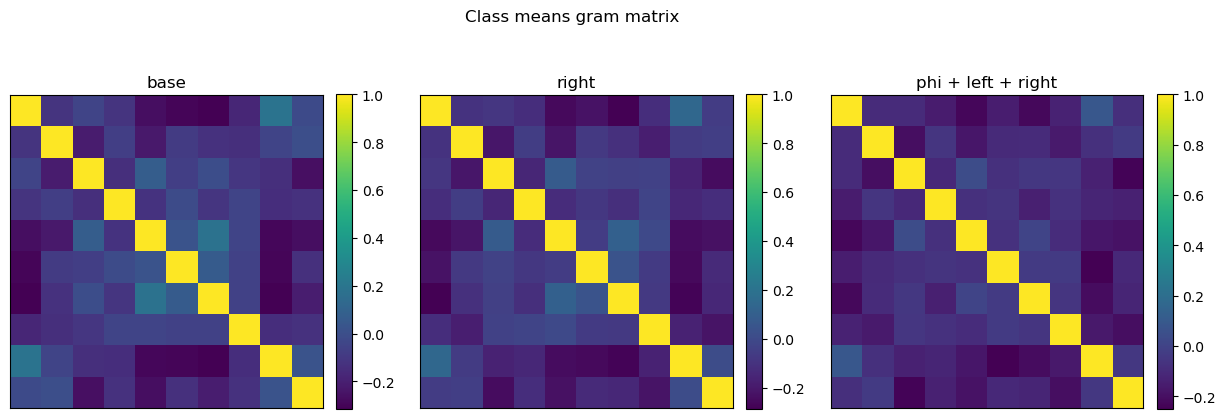

In [30]:
try:
    plt.close()
except:
    pass

layer = NUM_LAYERS - 1
# layer = 0

net = model.cuda()
if model_type=='mlp':
    fmap = get_fmap(net, layer)
    W = getW(net, layer)
elif model_type=='resnet18':
    fmap = get_fmap_resnet(net, layer)
    W = getW(net[1], layer)
    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

phiX = fmap(train_X)
_, _, _, mus  = get_class_variance(phiX, train_y)


U, S, Vt = torch.linalg.svd(W)
S = torch.diag(S)
if S.shape[1] != Vt.shape[0]:
            newS = torch.zeros(S.shape[0], Vt.shape[0]).to(S.device)
            newS[:,:S.shape[1]] = S.clone()
            S = newS

phiXr = phiX@Vt.T@S.T
_, _, _, mus_r = get_class_variance(phiXr, train_y)

phiXl = Activation()(phiX@W.T)
_, _, _, mus_l = get_class_variance(phiXl, train_y)
        
net.cpu()

u = mus - mus.mean(dim=0).unsqueeze(0)
u = u / u.norm(dim=1).unsqueeze(1)
uu = u@u.T
im1 = ax1.imshow(uu.detach().cpu())
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('base')

u = mus_r - mus_r.mean(dim=0).unsqueeze(0)
u = u / u.norm(dim=1).unsqueeze(1)
uu = u@u.T
im2 = ax2.imshow(uu.detach().cpu())
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('right')

u = mus_l - mus_l.mean(dim=0).unsqueeze(0)
u = u / u.norm(dim=1).unsqueeze(1)
uu = u@u.T
im3 = ax3.imshow(uu.detach().cpu())
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('phi + left + right')


fig.suptitle('Class means gram matrix')
fig.colorbar(im1, fraction=0.046, pad=0.04)
fig.colorbar(im2, fraction=0.046, pad=0.04)
fig.colorbar(im3, fraction=0.046, pad=0.04)
fig.set_size_inches(15, 5)
plt.show()

## All covariances, plots

In [18]:
def get_mu_cosines(u_):
    u = u_ - u_.mean(dim=0).unsqueeze(0)
    u = u / u.norm(dim=1).unsqueeze(1)
    uu = u@u.T
    return (uu.sum() - uu.trace()).item() / NUM_CLASSES / (NUM_CLASSES - 1)

In [ ]:
try:
    plt.close()
except:
    pass

layers_to_plot = 3

fig, axes = plt.subplots(5, layers_to_plot)

xsteps = torch.arange(0, len(models)*MEASURE_EVERY, MEASURE_EVERY).cpu()
# yticks = torch.linspace(0, 1, 11)

for layer in range(0,layers_to_plot):
    ax1 = axes[0][layer]
    ax2 = axes[1][layer]
    ax3 = axes[2][layer]
    ax4 = axes[3][layer]
    ax5 = axes[4][layer]
    
    right_covsW = []
    left_covsW = []
    base_covsW = []
    
    right_covsB = []
    left_covsB = []
    base_covsB = []
    
    right_covsWB = []
    left_covsWB = []
    base_covsWB = []
    
    right_covsW_B = []
    left_covsW_B = []
    base_covsW_B = []
    
    left_covs_mu = []
    right_covs_mu = []
    base_covs_mu = []
    
    for net in tqdm(models):
        net.cuda()
        W = getW(net, NUM_LAYERS-1-layer)
        fmap = get_fmap(net, NUM_LAYERS-1-layer)
        phiX = fmap(train_X)
        
        SigmaB, SigmaW, SigmaT, mus  = get_class_variance(phiX, train_y)
        covB, covW, covT = SigmaB.trace(), SigmaW.trace(), SigmaT.trace()
        
        U, S, Vt = torch.linalg.svd(W)
        S = torch.diag(S)
        
        phiXr = phiX@Vt.T@S
        SigmaBr, SigmaWr, SigmaTr, mus_r = get_class_variance(phiXr, train_y)
        covBr, covWr, covTr = SigmaBr.trace(), SigmaWr.trace(), SigmaTr.trace()
        
        phiXl = Activation()(phiX@W.T)
        SigmaBl, SigmaWl, SigmaTl, mus_l = get_class_variance(phiXl, train_y)
        covBl, covWl, covTl = SigmaBl.trace(), SigmaWl.trace(), SigmaTl.trace()
        
        
        covWB = torch.linalg.lstsq(SigmaB.cpu(), SigmaW.cpu(), driver='gelsd').solution.detach().trace().cpu()
        covWBr = torch.linalg.lstsq(SigmaBr.cpu(), SigmaWr.cpu(), driver='gelsd').solution.detach().trace().cpu()
        covWBl = torch.linalg.lstsq(SigmaBl.cpu(), SigmaWl.cpu(), driver='gelsd').solution.detach().trace().cpu()
        
        covB = covB.cpu().detach()
        covW = covW.cpu().detach()
        covT = covT.cpu().detach()
    
        covBr = covBr.cpu().detach()
        covWr = covWr.cpu().detach()
        covTr = covTr.cpu().detach()
        
        covBl = covBl.cpu().detach()
        covWl = covWl.cpu().detach()
        covTl = covTl.cpu().detach()
        
        
        base_covsW.append(covW/covT)
        right_covsW.append(covWr/covTr)
        left_covsW.append(covWl/covTl)
        
        base_covsB.append(covB/covT)
        right_covsB.append(covBr/covTr)
        left_covsB.append(covBl/covTl)
        
        base_covsWB.append(covWB)
        right_covsWB.append(covWBr)
        left_covsWB.append(covWBl)
        
        base_covsW_B.append(covW/covB)
        right_covsW_B.append(covWr/covBr)
        left_covsW_B.append(covWl/covBl)
        
        left_covs_mu.append(get_mu_cosines(mus_l))
        right_covs_mu.append(get_mu_cosines(mus_r))
        base_covs_mu.append(get_mu_cosines(mus))
        
        net.cpu()
    
    
    ax1.plot(xsteps, left_covsW, label="left")
    ax1.plot(xsteps, right_covsW, label="right")
    ax1.plot(xsteps, base_covsW, label="none")
    
    ax2.plot(xsteps, left_covsB, label="left")
    ax2.plot(xsteps, right_covsB, label="right")
    ax2.plot(xsteps, base_covsB, label="none")
    
    ax3.semilogy(xsteps, left_covsWB, label="left")
    ax3.semilogy(xsteps, right_covsWB, label="right")
    ax3.semilogy(xsteps, base_covsWB, label="none")
    
    ax4.semilogy(xsteps, left_covsW_B, label="left")
    ax4.semilogy(xsteps, right_covsW_B, label="right")
    ax4.semilogy(xsteps, base_covsW_B, label="none")
    
    
    ax5.plot(xsteps, left_covs_mu, label="left")
    ax5.plot(xsteps, right_covs_mu, label="right")
    ax5.plot(xsteps, base_covs_mu, label="none")
    
    ax1.set_title(f'Layer L-{layer+1}')
        
    # ax.set_yticks(yticks)
    
    if layer==0:
        ax1.set_ylabel(r'$tr(\Sigma_W) / tr(\Sigma_T)$', rotation=0)
        ax2.set_ylabel(r'$tr(\Sigma_B) / tr(\Sigma_T)$', rotation=0)
        ax3.set_ylabel(r'$tr(\Sigma_W \Sigma_B^\dagger)$', rotation=0)
        ax4.set_ylabel(r'$tr(\Sigma_W) / tr(\Sigma_B)$', rotation=0)
        ax5.set_ylabel(r'$\frac{1}{C(C-1)}\sum_{i \neq j} cos(\mu_i, \mu_j)$', rotation=0)
        
        ax1.yaxis.set_label_coords(-0.4,0.4)
        ax2.yaxis.set_label_coords(-0.4,0.4)
        ax3.yaxis.set_label_coords(-0.4,0.4)
        ax4.yaxis.set_label_coords(-0.4,0.4)
        ax5.yaxis.set_label_coords(-0.4,0.4)
        
    
    step = (len(models)-1)*MEASURE_EVERY // 4
    xticks = np.arange(0, (len(models)-1)*MEASURE_EVERY + step, step)
    
    ax1.set_xticks(xticks)
    ax2.set_xticks(xticks)
    ax3.set_xticks(xticks)
    ax4.set_xticks(xticks)
    ax5.set_xticks(xticks)
    
    # ax2.set_xlabel("Epochs")
    # ax3.set_xlabel("Epochs")
    # ax4.set_xlabel("Epochs")
    ax5.set_xlabel("Epochs")
    
handles, _ = axes[0][-1].get_legend_handles_labels()
labels = [r'$\mathrm{ReLU} (U S V^\top \Phi(X))$',
        r'$S V^\top \Phi(X)$',
        r'$\Phi(X)$']
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), fontsize=8, ncols=3)

fig.suptitle("Neural collapse across layers", y=1.1)
fig.set_size_inches(3*layers_to_plot, 15)
plt.show()
# plt.savefig(f'nn_figures/{dataset}_n_{n}_svd_nc_metrics.pdf', format='pdf', bbox_inches="tight")

  8%|▊         | 1/13 [00:00<00:09,  1.25it/s]